In [2]:
%pip install tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


### Compute co_occurrence matrix

In [128]:
# real data
file_real = "predictions_real.pkl"
file_real_new = "predictions_real_new.pkl"

# unmetered data mixed
file_100k = "predictions_100k_mixed_unmetered.pkl"
file_50k = "predictions_50k_mixed_unmetered.pkl"

# metered data mixed
file_50k_metered = "predictions_50k_mixed.pkl"
file_100k_metered = "predictions_100k_mixed.pkl"

# new 
file_50k_new = "predictions_50k_synthetic_new.pkl"


# data = pd.read_pickle("./shared/to_vid/predictions/"+file_real_new)
data = pd.read_pickle("./shared/to_vid/predictions/test_inception_pickle_all.pkl")
label_names = pd.read_pickle("./Energy_graph/data/labels_71.pkl")
co_occurrence_matrix = np.zeros((78, 78))
for d in data:
    y_test = d[1]
    y_pred_tf = d[0]
    # n_labels = y_test.shape[1]
    y_pred_tf = np.where(y_pred_tf > 0.3, 1, 0)

    for true, pred in zip(y_test, y_pred_tf):
        fn_labels = np.where((true == 1) & (pred == 0))[0]  # False negatives
        fp_labels = np.where((true == 0) & (pred == 1))[0]  # False positives

        for fn in fn_labels:
            for fp in fp_labels:
                co_occurrence_matrix[fn, fp] += 1


In [129]:
d[1]

array([3.8879e-02, 8.5220e-03, 1.4832e-01, 8.9050e-02, 1.4258e-01,
       4.3872e-01, 1.8604e-01, 1.1223e-02, 2.2339e-01, 7.6233e-02,
       1.1945e-01, 5.4047e-02, 7.8857e-02, 9.9976e-02, 1.1353e-01,
       2.0187e-02, 7.5745e-02, 2.1957e-02, 1.2268e-01, 3.4229e-01,
       5.2155e-02, 1.7761e-01, 1.2805e-01, 1.1584e-01, 3.2178e-01,
       2.9683e-04, 1.6663e-01, 3.4821e-02, 1.2073e-01, 4.6143e-02,
       1.4214e-02, 8.3313e-02, 2.4109e-02, 1.2512e-01, 1.6022e-02,
       3.3020e-02, 5.7764e-01, 7.1045e-02, 1.3666e-03, 1.0431e-01,
       1.1896e-01, 1.6003e-01, 3.9032e-02, 7.4268e-01, 6.2256e-02,
       1.8677e-01, 1.0815e-01, 1.4465e-02, 7.5562e-02, 6.4844e-01,
       3.8269e-02, 4.1577e-01, 8.5510e-02, 2.0776e-01, 3.3496e-01,
       1.0315e-01, 5.5450e-02, 3.9429e-02, 1.6281e-02, 1.8173e-02,
       8.2932e-03, 9.3555e-01, 1.6861e-02, 2.8784e-01, 2.7954e-01,
       3.8269e-02, 5.3825e-03, 4.5264e-01, 1.3609e-03, 4.0161e-01,
       6.1951e-02], dtype=float16)

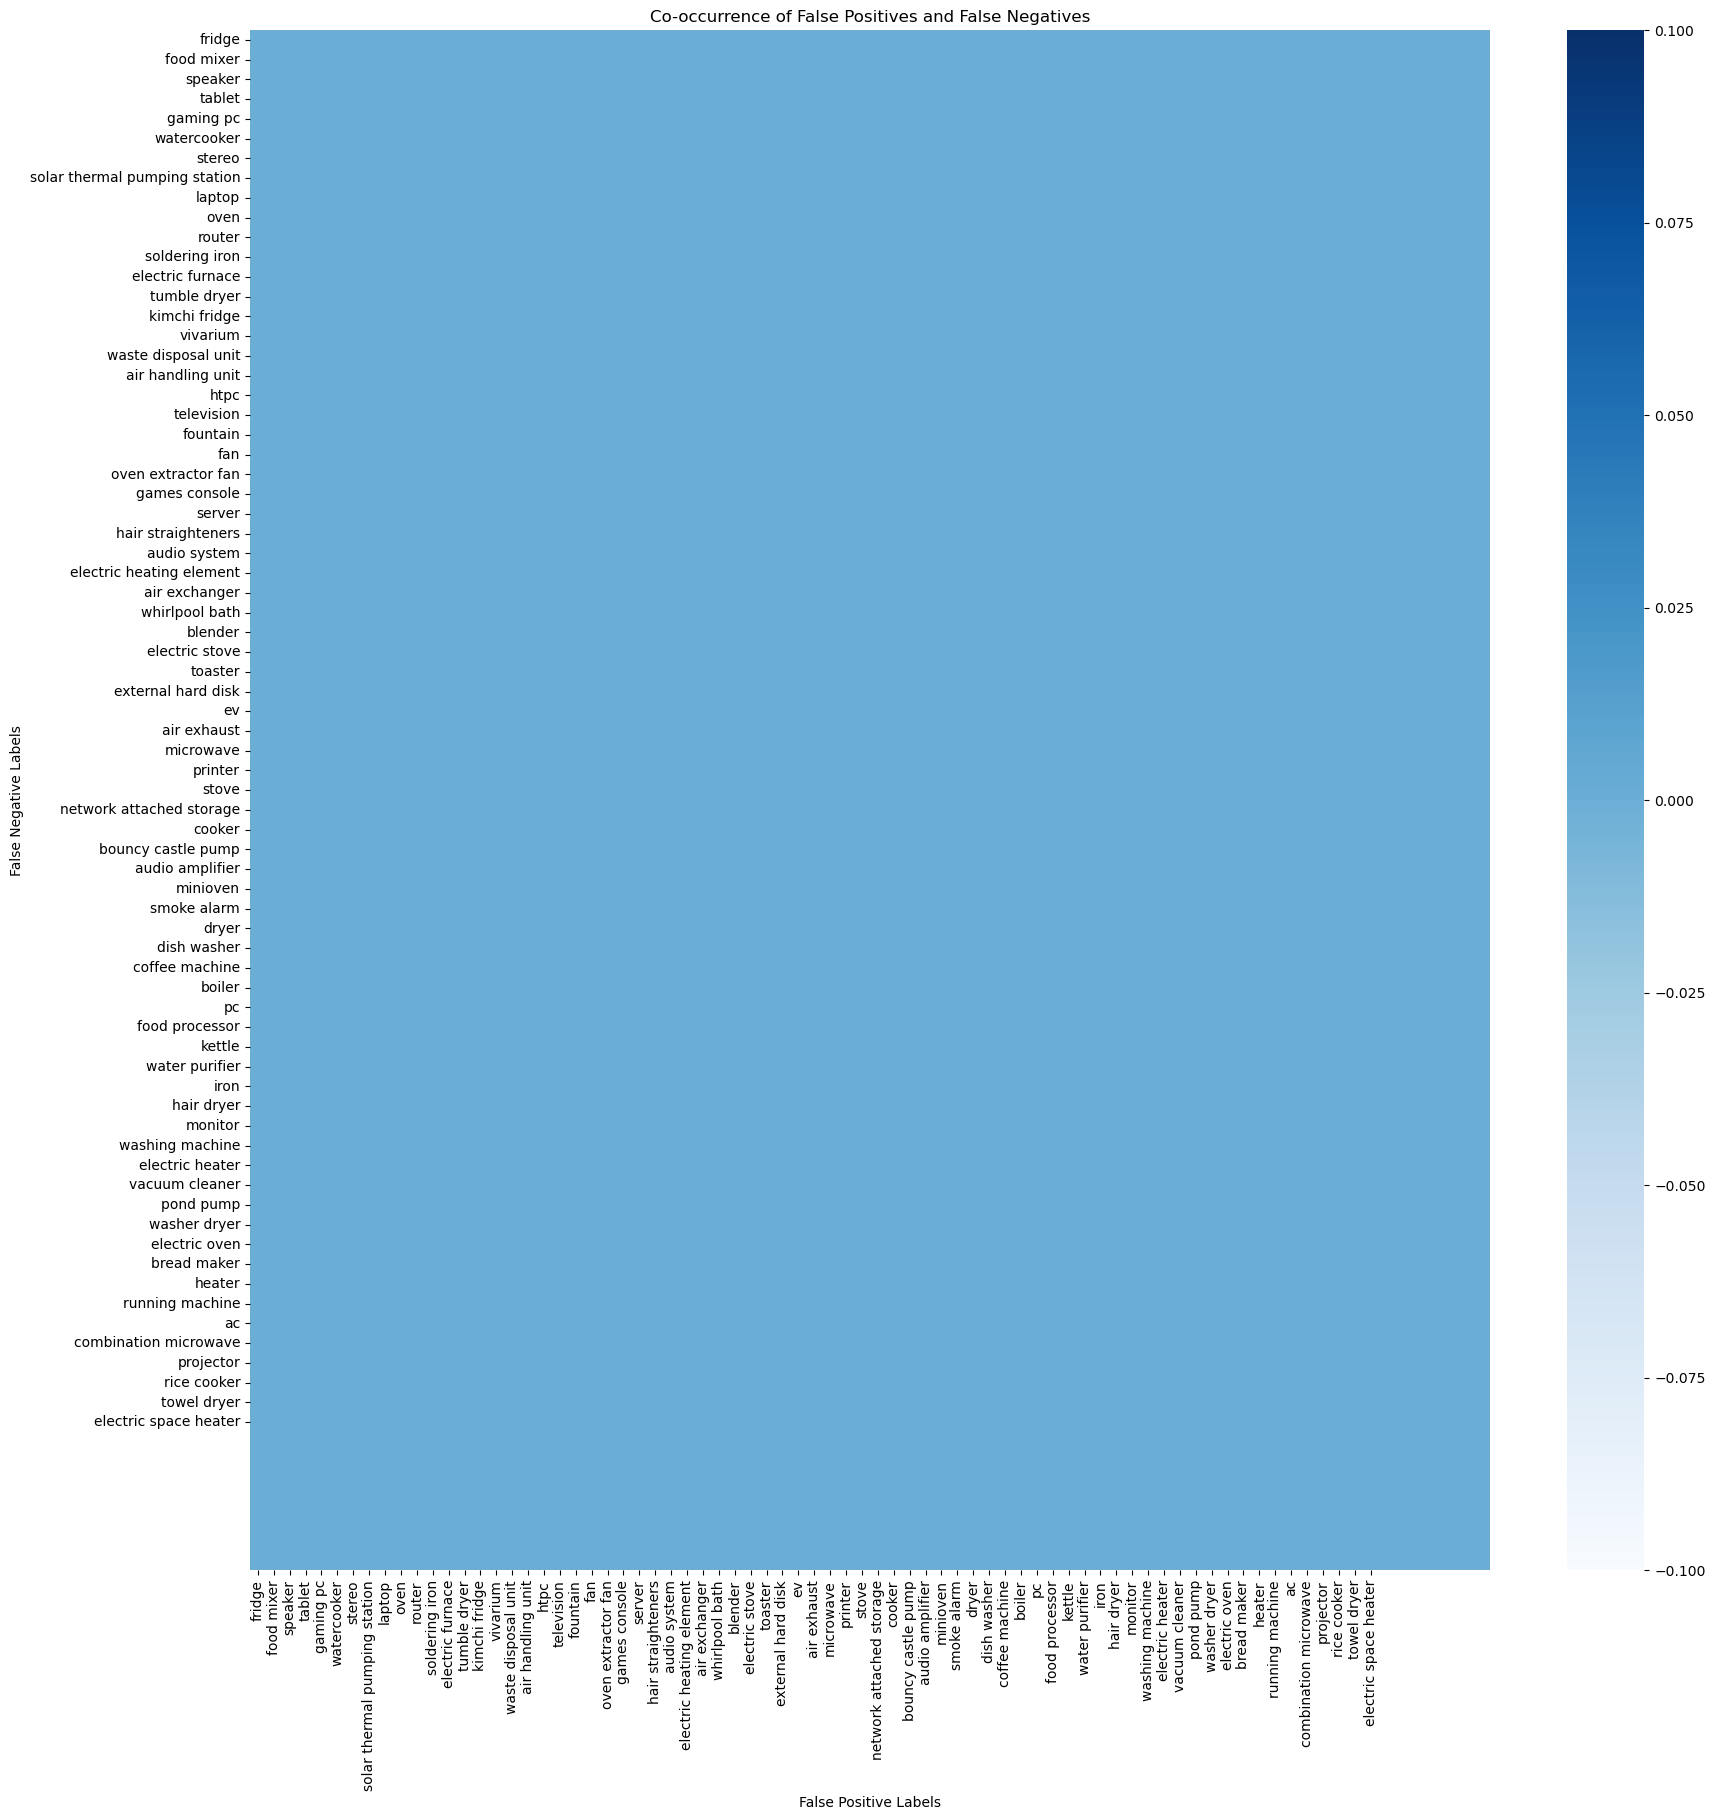

In [132]:

plt.figure(figsize=(20, 20))
sns.heatmap(co_occurrence_matrix, fmt='g', cmap='Blues')

plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=90)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
plt.xlabel('False Positive Labels')
plt.ylabel('False Negative Labels')
plt.title('Co-occurrence of False Positives and False Negatives')
plt.show()

### Get average missed devices the model predicted

In [134]:
data = pd.read_pickle("./shared/to_vid/predictions/test_inception_pickle_all.pkl")
label_names = pd.read_pickle("./Energy_graph/data/labels_71.pkl")
count = []
for d in tqdm(data):
    y_test = d[1]
    y_pred_tf = d[0]
    for w in range(len(y_test)):
        # test = y_test[w].count(True)
        # pred = y_pred_tf[w].count(True)

        test = np.sum(y_test[w])
        pred = np.sum(y_pred_tf[w])

        c = test - pred
        count.append(c)
    
count = np.array(count)
print(f"Average wrong number of devices predicted: {abs(count).mean()}")
print(f"Median wrong number of devices predicted: {np.median(count)}")


  0%|          | 0/3 [00:00<?, ?it/s]

Average wrong number of devices predicted: 0.17286377221765653
Median wrong number of devices predicted: 0.0


### Most common mislabelled devices

In [136]:
# Calculate total misclassifications for each label
misclassifications = np.sum(co_occurrence_matrix, axis=0) + np.sum(co_occurrence_matrix, axis=1)

# Get indices of top 10 misclassified labels
top_10_indices = np.argsort(misclassifications)[-20:][::-1]

# Extract their names and most commonly mistaken labels
top_10_labels_with_mistakes = []
for idx in top_10_indices:
    # Check both false positives (column) and false negatives (row)
    mistaken_for_idx_fp = np.argmax(co_occurrence_matrix[:, idx]) # false positives
    mistaken_for_idx_fn = np.argmax(co_occurrence_matrix[idx, :]) # false negatives
    
    # Depending on which is greater, pick the most common mistaken label
    if co_occurrence_matrix[mistaken_for_idx_fp, idx] > co_occurrence_matrix[idx, mistaken_for_idx_fn]:
        mistaken_for_idx = mistaken_for_idx_fp
    else:
        mistaken_for_idx = mistaken_for_idx_fn
    
    mistaken_label = label_names[mistaken_for_idx]
    top_10_labels_with_mistakes.append((label_names[idx], mistaken_label))

print("Top 10 most mislabeled labels and the labels they're most often mistaken for:")
for main_label, mistaken_label in top_10_labels_with_mistakes:
    print(f"{main_label} - {mistaken_label}.")


Top 10 most mislabeled labels and the labels they're most often mistaken for:
towel dryer - pc.
fan - pc.
cooker - pc.
laptop - pc.
router - pc.
washing machine - pc.
rice cooker - pc.
external hard disk - pc.
audio system - pc.
tablet computer charger - pc.
dish washer - pc.
soldering iron - pc.
radio - pc.
usb hub - pc.
printer - pc.
htpc - pc.
oven - pc.
baby monitor - pc.
vacuum cleaner - pc.
fridge - pc.


In [21]:
data = pd.read_pickle("./shared/to_vid/predictions/test_inception_pickle_0.pkl")
x = np.array([np.sum(a) for a in data[0]])
x.min()

0

In [24]:
data[2][1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float16)

### Treshold testing

In [14]:
from sklearn import metrics
# predictions.append((y_pred_tf, y_test, y_pred))
# data = pd.read_pickle("./shared/to_vid/predictions/test_inception_pickle_.pkl")
label_names = pd.read_pickle("./Energy_graph/data/labels_new.pkl")
df_all = pd.DataFrame()
threshold = 0.3
# for i in range(5)
data = pd.read_pickle(f"./shared/to_vid/predictions/test_inception_pickle_d10_more_epochs.pkl")

for 
y_pred = data[2]
y_test = data[1]
y_pred_tf = (y_pred > threshold).astype(int)
report = metrics.classification_report(y_test, y_pred_tf, target_names=label_names, zero_division=0, output_dict=True)
df = (pd.DataFrame(report).T)
# df = df.rename(columns={"f1-score": f"f1-score_{i}"})
# df_all = pd.concat([df_all, df], axis=1)

# df.to_csv("results_0_t30.csv")
curr_y = 0
test = {
    "pred(%)" : y_pred[curr_y],
    "pred_tf": y_pred_tf[curr_y],
    "real": y_test[curr_y]
}

df

,precision,recall,f1-score,support
microwave,0.345326,0.620090,0.443608,4659.0
air exchanger,0.335266,0.261099,0.293570,2658.0
combination microwave,0.517529,0.326430,0.400344,2849.0
router,0.460526,0.094563,0.156907,2961.0
water purifier,0.697301,0.735951,0.716105,2598.0
...,...,...,...,...
stove,0.789653,0.928371,0.853412,2499.0
micro avg,0.508971,0.477064,0.492501,188742.0
macro avg,0.475364,0.432536,0.431145,188742.0
weighted avg,0.483367,0.477064,0.457149,188742.0


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score
from random import randint

curr_y = randint(0, len(y_test))
# i =215
test = {
    "pred(%)" : y_pred[curr_y],
    "pred_tf": y_pred_tf[curr_y],
    "real": y_test[curr_y],
    "label": label_names
}

# f1 = f1_score(y_test[curr_y], y_pred_tf[curr_y], average='macro')  # Use 'micro', 'macro', or 'weighted' for multilabel classification
# precision = precision_score(y_test[curr_y], y_pred_tf[curr_y])  # adjust 'average' parameter as needed
# recall = recall_score(y_test[curr_y], y_pred_tf[curr_y])  # adjust 'average' parameter as needed
# print("F1: ",f1, "Precision: ", precision, "Recall: ", recall)

# Adding F1 score as a column
# df['F1 Score'] = [f1]*len(df)

# Displaying the first 50 rows
mislabelled = pd.DataFrame(test)
mislabeled_mask = mislabelled['pred_tf'] != mislabelled['real']
mislabelled[mislabeled_mask]

,pred(%),pred_tf,real,label
2,0.002037,0,1,combination microwave
3,0.096130,0,1,router
8,0.081909,0,1,pc
11,0.412109,1,0,television
51,0.034332,0,1,speaker


# Timeseries comparisons


In [3]:
labels = pd.read_pickle("./Energy_graph/data/labels_new.pkl")
data = pd.read_pickle("./Energy_graph/data/device_windows/processed_watts.pkl")



In [435]:
arr =[]
for k in data:
    arr.append((len(data[k]), k))

arr.sort(key=lambda x: x[0], reverse=True)
arr

[(87500, 'fridge'),
 (38548, 'television'),
 (21394, 'pc'),
 (19836, 'kettle'),
 (15644, 'microwave'),
 (11113, 'washing machine'),
 (9793, 'dish washer'),
 (9174, 'router'),
 (8244, 'toaster'),
 (6112, 'boiler'),
 (6107, 'external hard disk'),
 (5951, 'audio system'),
 (5605, 'htpc'),
 (5326, 'oven'),
 (4307, 'kimchi fridge'),
 (4117, 'laptop'),
 (3594, 'tumble dryer'),
 (3482, 'speaker'),
 (3307, 'solar thermal pumping station'),
 (2977, 'audio amplifier'),
 (2842, 'washer dryer'),
 (2764, 'monitor'),
 (2737, 'food processor'),
 (2315, 'coffee machine'),
 (2197, 'bouncy castle pump'),
 (2068, 'rice cooker'),
 (1787, 'vivarium'),
 (1422, 'tablet'),
 (1317, 'combination microwave'),
 (1076, 'pond pump'),
 (1058, 'stereo'),
 (951, 'electric heater'),
 (802, 'dryer'),
 (762, 'blender'),
 (692, 'hair dryer'),
 (615, 'running machine'),
 (599, 'electric heating element'),
 (574, 'ac'),
 (530, 'server'),
 (488, 'bread maker'),
 (481, 'water purifier'),
 (433, 'hair straighteners'),
 (431, '

In [12]:
import re

def preprocess_string(string : str) -> str:
    string = string.lower().strip()
    string = re.sub(' +', ' ', string)
    string = string.replace("_", " ")
    string = string.replace("-", " ")
    string = string.replace("&", " ")
    string = string.split("(")[0]
    string = string.split("#")[0]

    string = string.strip()

    # handle known synoynms
    synonyms = {
        "refrigerator": "fridge",
        "vaccumcleaner": "vacuum cleaner",
        "breadmaker": "bread maker",
      
        
    }
    if "freezer" in string:
        string = "fridge"

    if string in synonyms:
        string = synonyms[string]

    if 'hi fi' in string:
        string = "audio system"

    if "router" in string:
        string = "router"

    if "treadmill" in string:
        string = "running machine"
        

    if "laptop" in string:
        string = "laptop"
    
    if "server" in string:
        string = "server"

    if "monitor" in string and not "baby" in string:
        string = "monitor"
    # special cases
    if "computer" in string and "charger" not in string:
        string = "pc"

    if "tv" in string:
        string = "television"

    if "television" in string:
        string = "television"

    if "macbook" in string:
        string = "laptop"
        
    if "car charger" == string:
        string = "ev"
    
    if "toast" in string:
        string = "toaster"
    
    if "modem" in string:
        string = "router"

    # we treat all audio devices as speakers so subwoofer is also a speaker
    if "subwoofer" in string:
        string = "speaker"

    if "speaker" in string:
        string = "speaker"

    if "iron" in string and "soldering" not in string:
        string = "iron"

    
    if "coffeemachine" in string:
        string = "coffee machine"
    if "coffee maker" in string:
        string = "coffee machine"

    if "dishwasher" in string:
        string = "dish washer"
    if "air conditioner" in string:
        string = "ac"

    if "air conditioning" in string:
        string = "ac"
    
    string = re.sub(' +', ' ', string)
    string = re.sub(r'\d+', '', string)
    return string.strip()


In [13]:
import os
path = "./Energy_graph/data/processed_watts/"

for f in os.listdir(path):
    if f.endswith(".pkl"):
        data = pd.read_pickle(path+f)
        print("*****************************************************************************************")
        for h in data:
            print(h)
            print(sorted([preprocess_string(s) for s in list(data[h].keys())]))

*****************************************************************************************
UKDALE_5
['aggregate', 'audio amplifier', 'coffee machine', 'dish washer', 'electric oven', 'electric stove', 'fridge', 'games console', 'hair dryer', 'iron', 'kettle', 'microwave', 'monitor', 'network attached storage', 'pc', 'running machine', 'server', 'speaker', 'television', 'toaster', 'vacuum cleaner', 'washer dryer']
UKDALE_2
['aggregate', 'cooker', 'dish washer', 'external hard disk', 'fridge', 'games console', 'kettle', 'laptop', 'microwave', 'monitor', 'pc', 'rice cooker', 'router', 'router', 'running machine', 'speaker', 'toaster', 'washing machine']
UKDALE_1
['aggregate', 'audio amplifier', 'audio system', 'boiler', 'bouncy castle pump', 'bread maker', 'coffee machine', 'dish washer', 'external hard disk', 'fan', 'food processor', 'fridge', 'hair dryer', 'hair straighteners', 'htpc', 'iron', 'laptop', 'microwave', 'monitor', 'oven', 'pc', 'printer', 'router', 'solar thermal pumping sta

tablet


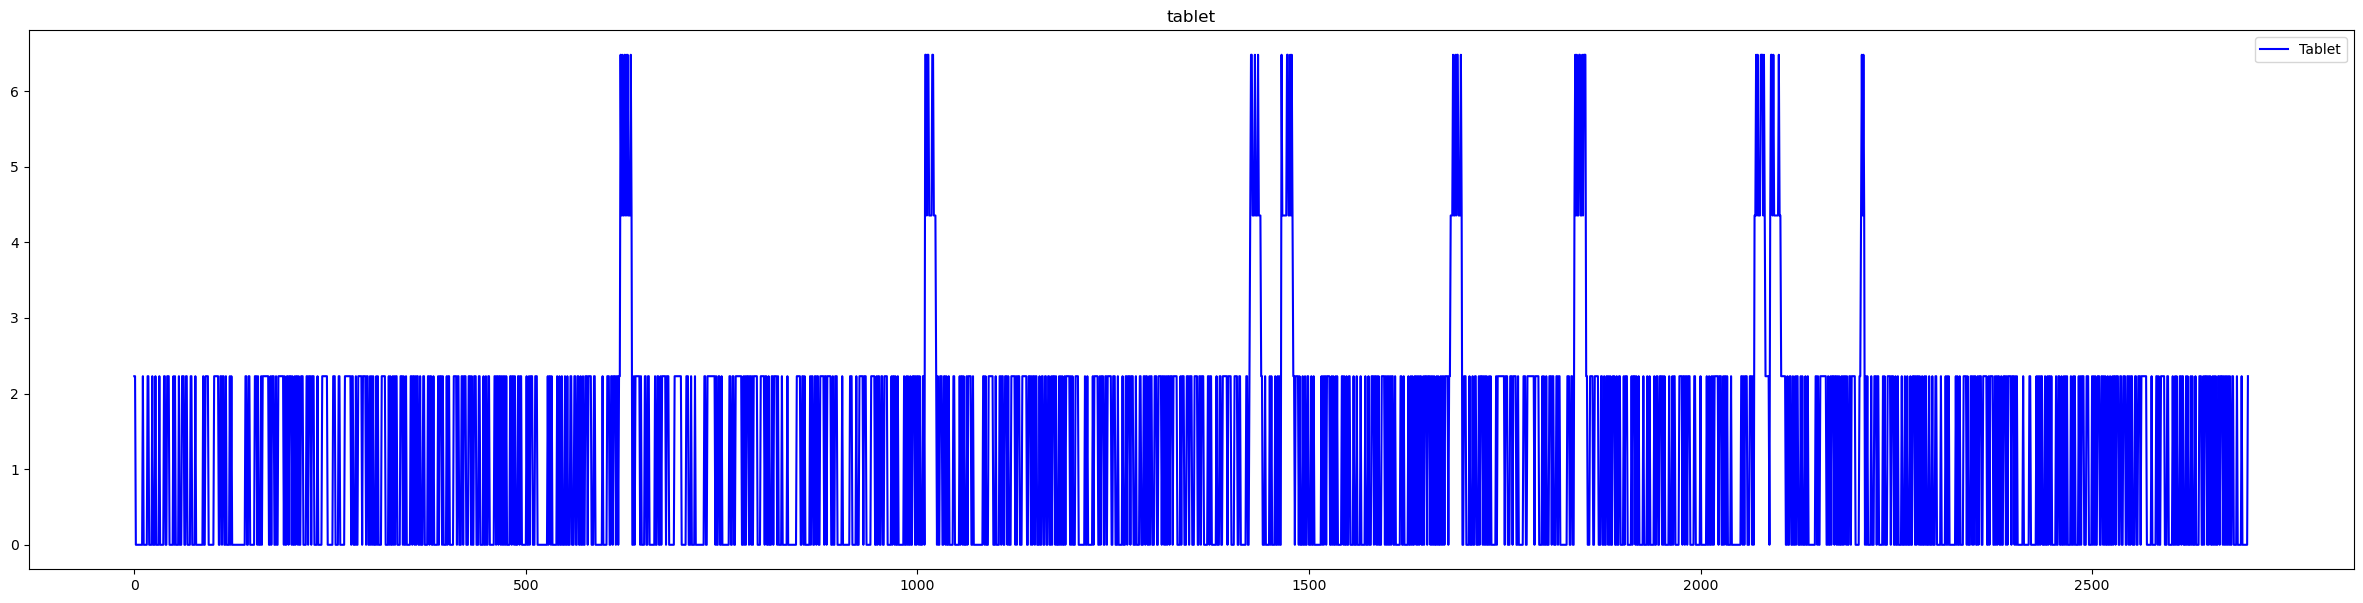

In [9]:

# skip=["pc", "coffee machine", "electric stove", "server", "running machine", "electric stove", "electric oven","iron"]
from random import choice
for k in data:
    if k != "tablet":
        continue
    print(k)

    n=len(data[k])

    c = choice(range(n))
    # print(np.size(data[k][c]))
    # data[data[k][c]].plot(title=k, color="blue", figsize=(35, 7))
    mask = data[k][c].values>0
    data[k][c].plot(title=k, color="blue", figsize=(30, 7))
    # padded_data = np.pad(data[k][c].values[mask], pad_width=50, mode='constant', constant_values=0)
    # plt.plot(padded_data, color="blue")


plt.show()


<AxesSubplot: >

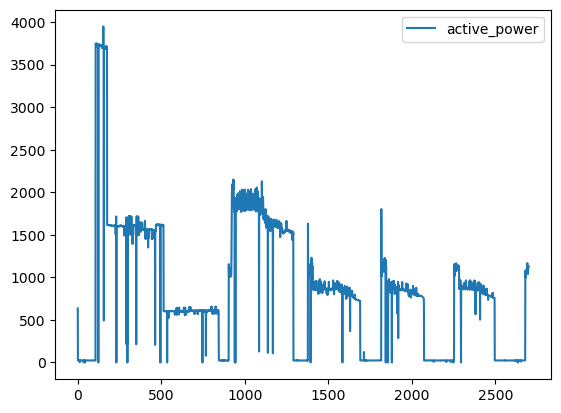

In [41]:
data["kimchi fridge"][0].plot()

<AxesSubplot: >

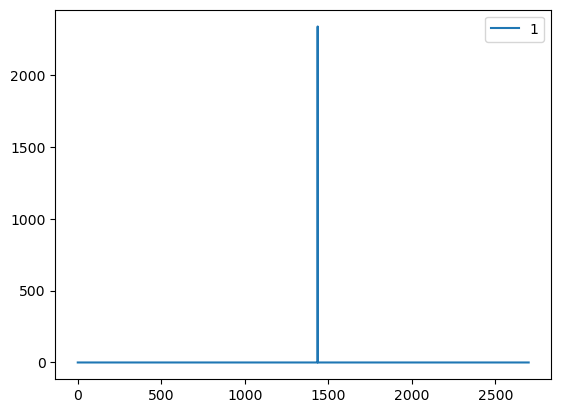

In [51]:
data["mobile phone charger"][6].plot()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randint

In [19]:
data = pd.read_pickle("./Energy_graph/data/processed_watts/REFIT_clean.pkl")
data["REFIT_20"].keys()



dict_keys(['aggregate', ' fridge', ' freezer', ' tumble dryer', ' washing machine', ' dishwasher', ' computer site', ' television site', ' microwave', ' kettle'])

In [20]:
data["REFIT_20"][' kettle']= data["REFIT_20"][' kettle'].dropna()
data["REFIT_20"][' kettle'][data["REFIT_20"][' kettle'] > 0].head(50)

,kettle
Time,
2014-03-20 12:01:12,NaN
2014-03-20 12:01:20,NaN
2014-03-20 12:01:28,NaN
2014-03-20 12:01:36,NaN
2014-03-20 12:01:44,NaN
2014-03-20 12:01:52,NaN
2014-03-20 12:02:00,NaN
2014-03-20 12:02:08,NaN
2014-03-20 12:02:16,NaN


In [29]:
all_data = pd.read_pickle("./Energy_graph/data/training_data/real_house.pkl")
all_data.keys()


dict_keys(['IAWE_1', 'HES_1', 'REDD_1', 'REDD_2', 'REDD_3', 'REDD_4', 'REDD_5', 'REDD_6', 'DRED_1', 'HEART_33', 'HEART_7', 'DEDDIAG_8', 'ECO_1', 'ECO_6', 'ECO_2', 'ECO_5', 'ECO_4', 'ECO_3', 'ENERTALK_1', 'ENERTALK_18', 'ENERTALK_12', 'ENERTALK_20', 'ENERTALK_15', 'ENERTALK_6', 'ENERTALK_8', 'ENERTALK_2', 'ENERTALK_11', 'ENERTALK_16', 'ENERTALK_5', 'ENERTALK_7', 'ENERTALK_14', 'ENERTALK_13', 'ENERTALK_19', 'ENERTALK_21', 'ENERTALK_0', 'ENERTALK_4', 'ENERTALK_17', 'ENERTALK_10', 'ENERTALK_3', 'ENERTALK_9', 'REFIT_13', 'REFIT_6', 'REFIT_1', 'REFIT_21', 'REFIT_8', 'REFIT_9', 'REFIT_20', 'REFIT_7', 'REFIT_15', 'REFIT_12', 'REFIT_4', 'REFIT_3', 'REFIT_18', 'REFIT_11', 'REFIT_16', 'REFIT_17', 'REFIT_10', 'REFIT_19', 'REFIT_2', 'REFIT_5', 'UKDALE_5', 'UKDALE_2', 'UKDALE_1', 'UKDALE_3'])

In [24]:
# data= pd.read_pickle("./Energy_graph/data/training_data/processed/X_Y_wsize2688_upper32_gap3600_numD64.pkl")
# # data = pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl") 
# data_syn_ideal = pd.read_pickle("./Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl") 
# data_syn_unmetered = pd.read_pickle("./Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_unmetered.pkl")

labels = pd.read_pickle("./Energy_graph/data/labels_new.pkl")
# X_syn_ideal = np.array([i[0] for i in data_syn_ideal])
# y_syn_ideal = np.array([i[1] for i in data_syn_ideal])

# X_syn_unmetered = np.array([i[0] for i in data_syn_unmetered])
# y_syn_unmetered = np.array([i[1] for i in data_syn_unmetered])

# X_real = np.array([i[0] for i in data])
# y_real = np.array([i[1] for i in data])
data = all_data["ENERTALK_1"]

X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])

# data_syn_X = np.concatenate((X_syn_ideal,X_syn_unmetered), axis=0)
# data_syn_y = np.concatenate((y_syn_ideal, y_syn_unmetered), axis=0)

# X = np.concatenate((X, X_syn_ideal,X_syn_unmetered), axis=0)
# y = np.concatenate((y, y_syn_ideal, y_syn_unmetered), axis=0)





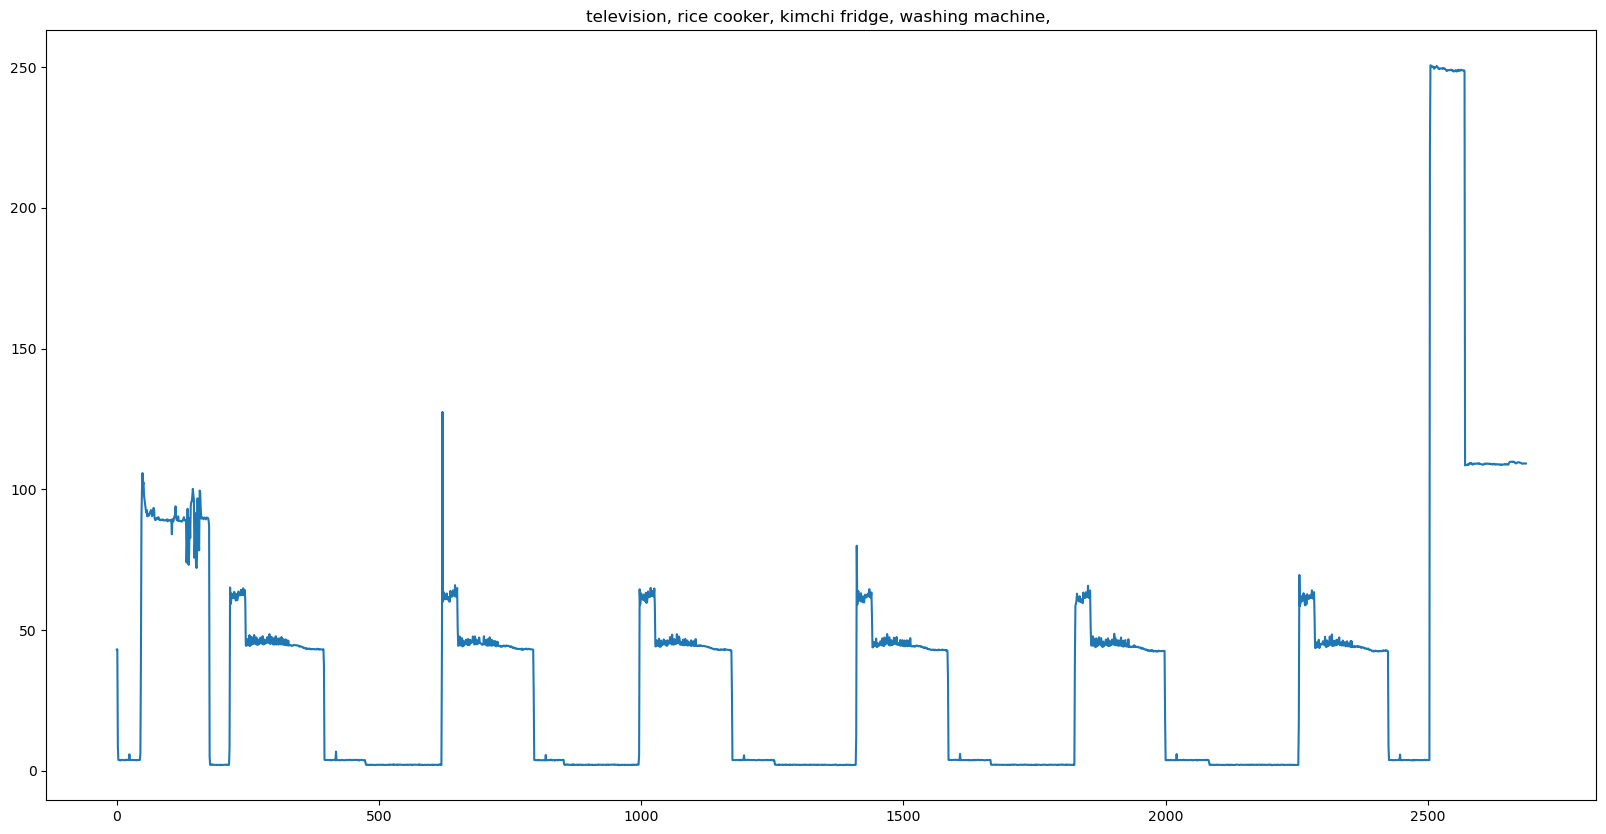

In [28]:
plt.figure(figsize=(20, 10))
ix =randint(0, len(X))
# ix = 608
sample = X[ix]
lables_tf = y[ix]
title = ""
for curr_y, lab in enumerate(labels):
    if lables_tf[curr_y]:
        title += lab + ", "

plt.title(title)
plt.plot(X[ix])
plt.savefig("sample_1.pdf", format="pdf")
plt.show()

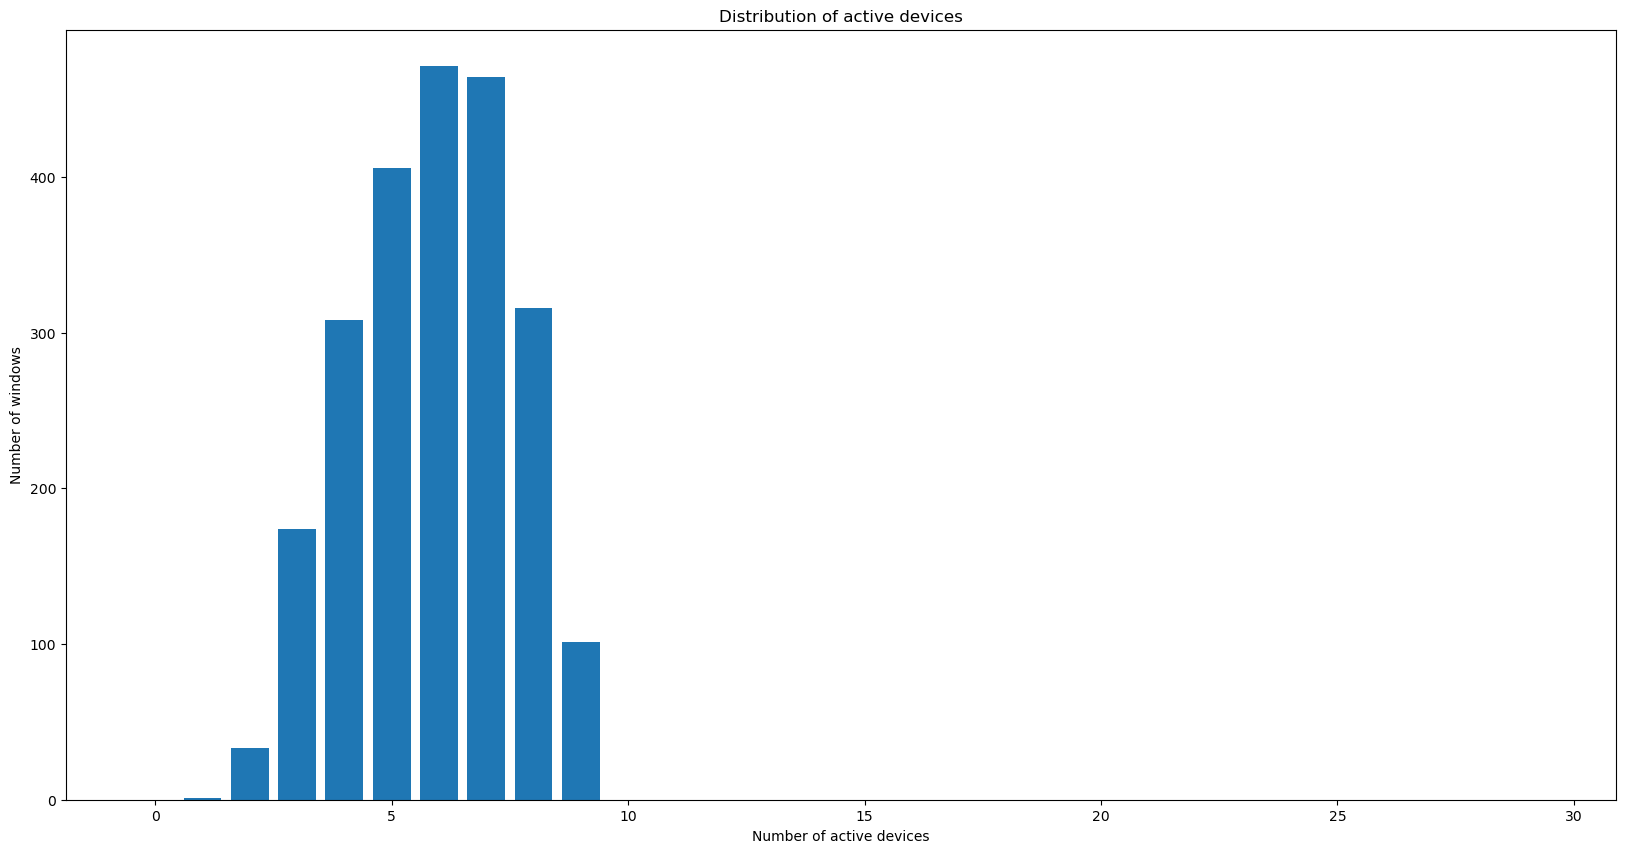

In [53]:
plt.figure(figsize=(20, 10))
arr = np.zeros(30)
for ix, curr_y in enumerate(y):
    x = np.sum(curr_y)
    # if x == 0:
    #     print(ix)
    arr[x]+=1
plt.title("Distribution of active devices")
plt.xlabel("Number of active devices")
plt.ylabel("Number of windows")
plt.bar(range(len(arr)), arr)
plt.savefig("distribution.pdf", format="pdf")
   

In [ ]:
toaster = pd.read_pickle("./")

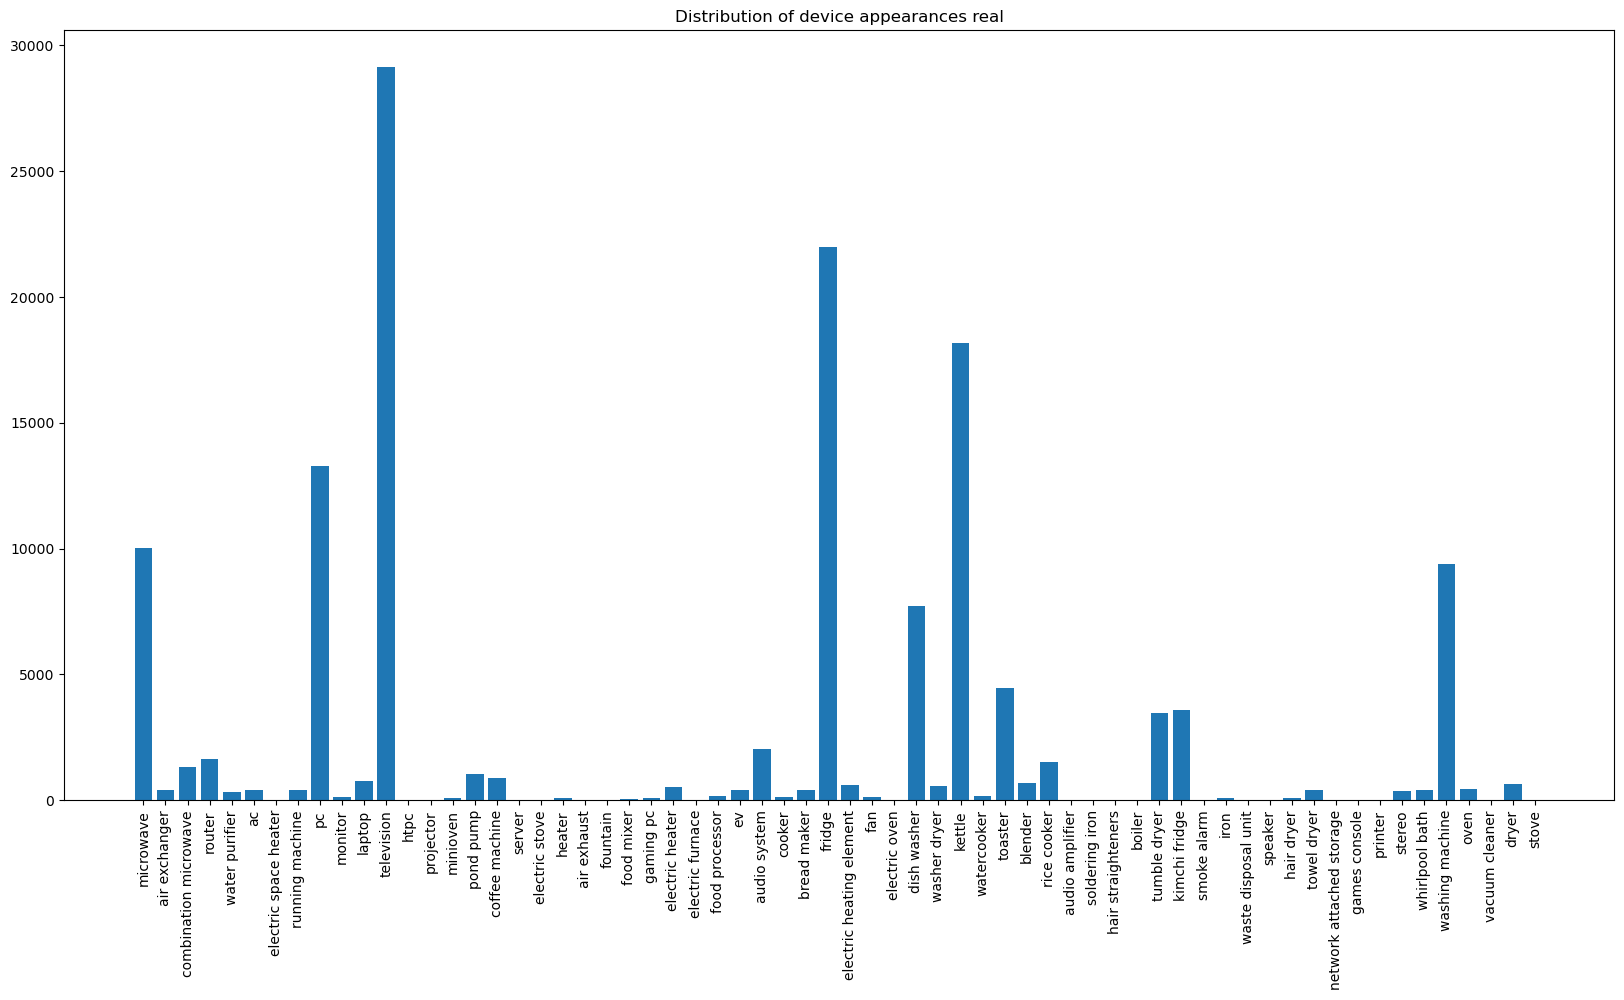

In [87]:
plt.figure(figsize=(20, 10))
distribution_devices = np.zeros(len(labels))
for arr in y_real:
    distribution_devices += arr
# Assuming distribution_devices is a list of numeric values (e.g., counts or measurements)
# And labels is a list of strings corresponding to each category

plt.title("Distribution of device appearances real")
num_labels = len(labels)  # Determine the number of labels/categories
plt.bar(range(num_labels), distribution_devices)  # Create a bar chart
plt.xticks(range(num_labels), labels, rotation=90)  # Set the labels for each bar with a 90-degree rotation
plt.savefig("distribution_of_device_appearances_real.pdf", format="pdf")
plt.show()  # Display the plot

In [33]:
import pandas as pd

data = pd.read_pickle("./Energy_graph/data/processed_watts/REFIT_clean.pkl")

data["REFIT_2"].keys()

dict_keys(['aggregate', ' fridge-freezer', ' washing machine', ' dishwasher', ' television', ' microwave', ' toaster', ' hi-fi', ' kettle'])

# Buckaroo testing

In [14]:
%pip install buckaroo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import buckaroo